In [1]:
!pip install datasets
!pip install transformers
!pip install peft
!pip install accelerate
!pip install bitsandbytes
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [2]:
pip install --upgrade bitsandbytes


In [3]:
#huggingface login
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `absa3` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate wh

In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
import ast
import torch

from datasets import load_dataset
from transformers import (
    LlamaForCausalLM,
    LlamaTokenizer,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType

In [18]:
import pandas as pd

In [38]:
def load_data():
    # Example: using local CSV files. Adjust these paths to your own.
    # If you already have your data as a Hugging Face DatasetDict, skip this step.
    dataset = load_dataset("csv", data_files={
        "train": "/content/drive/MyDrive/T5_finetuning/Dataset2/Restaurant2014/Train /Restaurants_Train_Formatted.csv",
        "validation": "/content/drive/MyDrive/T5_finetuning/Dataset2/Restaurant2014/Test/Restaurants_Test_Gold_Formatted.csv",
        "test": "/content/drive/MyDrive/T5_finetuning/Dataset2/Laptop2014/Trial/laptops_Trial_Formatted.csv"
    })

    return dataset

In [22]:
def format_aspect_pairs(aspect_str):
    # If there are no aspect terms
    if aspect_str == "noaspectterms":
        return "noaspectterms"

    # Otherwise parse the string into a list of dicts
    try:
        data = ast.literal_eval(aspect_str)
    except:
        # If there's an error in parsing, return 'noaspectterms' or handle differently
        return "noaspectterms"

    lines = []
    for item in data:
        term = item.get('term', '')
        polarity = item.get('polarity', '')
        lines.append(f"{term}:{polarity}")
    return "\n".join(lines)

In [23]:
def create_prompt_and_response(ex):
    raw_text = ex["raw_text"]
    aspects_str = ex["aspectTerms"]

    # Build the prompt
    prompt = (
        "Below is a product/service-related text. "
        "Identify any aspects and their sentiment polarity.\n"
        "Return the result as 'aspect:polarity' pairs. If none exist, return 'noaspectterms'.\n\n"
        f"Text:\n{raw_text}\n\nAnswer:\n"
    )

    # Build the response
    answer = format_aspect_pairs(aspects_str)

    return {
        "input_text": prompt,
        "target_text": answer
    }

In [24]:
def tokenize_fn(examples, tokenizer, max_length=512):
    inputs = []
    for prompt, ans in zip(examples["input_text"], examples["target_text"]):
        # Combine them
        full_text = prompt + ans
        inputs.append(full_text)

    tokenized = tokenizer(
        inputs,
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    # For causal LM, labels are the same as input_ids by default
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized


In [25]:
def get_llama_model_and_tokenizer(model_id="meta-llama/Llama-2-7b-hf"):
    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    tokenizer = LlamaTokenizer.from_pretrained(model_id)
    # Set pad_token = eos_token if not already set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    base_model = LlamaForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )

    return base_model, tokenizer

In [26]:
def apply_qlora(base_model):
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    peft_model = get_peft_model(base_model, lora_config)
    peft_model.print_trainable_parameters()
    return peft_model

In [27]:
def train_model(model, tokenizer, dataset, output_dir="/content/drive/MyDrive/GPTo3-mini-llama2-7b/JointTask/Output/llama2-7b-qlora-aspect-sentiment_res14"):
    # Map dataset to prompt/response
    dataset = dataset.map(create_prompt_and_response)

    # Tokenize
    def collate_fn(examples):
        return tokenize_fn(examples, tokenizer, max_length=512)

    # It's usually better to use .map(...) to tokenize rather than collate_fn,
    # but we'll do a simple approach here.
    tokenized_dataset = dataset.map(
        lambda x: collate_fn(x), batched=True, remove_columns=dataset["train"].column_names
    )

    train_dataset = tokenized_dataset["train"]
    eval_dataset = tokenized_dataset["validation"]

    # Set up training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        evaluation_strategy="steps",
        eval_steps=100,
        logging_steps=50,
        save_steps=200,
        save_total_limit=2,
        learning_rate=2e-4,
        fp16=True,
        report_to="tensorboard"  # or "tensorboard" etc.
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    trainer.train()
    return trainer

In [28]:
def predict_aspects(model, tokenizer, text):
    prompt = (
        "Below is a product/service-related text. "
        "Identify any aspects and their sentiment polarity.\n"
        "Return the result as 'aspect:polarity' pairs. If none exist, return 'noaspectterms'.\n\n"
        f"Text:\n{text}\n\nAnswer:\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        generation = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=True,
            top_p=0.9,
            temperature=0.7,
        )
    output = tokenizer.decode(generation[0], skip_special_tokens=True)

    # Extract content after 'Answer:'
    if "Answer:" in output:
        output = output.split("Answer:", 1)[1]

    # Remove only leading whitespace on the first line
    output_lines = output.split("\n")
    if len(output_lines) > 1:
        # apply .lstrip() to only the second line
        output_lines[1] = output_lines[1].lstrip()
    output = "\n".join(output_lines)



    return output


In [33]:
def main():
    # 1. Load Data
    dataset = load_data()  # modifies this for your actual data

    # 2. Load Base Model and Tokenizer
    base_model, tokenizer = get_llama_model_and_tokenizer()

    # 3. Apply QLoRA
    qlora_model = apply_qlora(base_model)

    # 4. Train
    trainer = train_model(qlora_model, tokenizer, dataset)

    # 5. Inference Example
    test_text = "The food was lousy - too sweet or too salty and the portions tiny."  # sample text

    # Merging LoRA weights is optional. If you want to merge:
    # qlora_model = qlora_model.merge_and_unload()

    # Predict aspects
    prediction = predict_aspects(qlora_model, tokenizer, test_text)
    print("Prediction:\n", prediction)


if __name__ == "__main__":
    main()


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

trainable params: 16,777,216 || all params: 6,755,192,832 || trainable%: 0.2484


Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.112100,0.106378
200,0.103700,0.105382
300,0.103900,0.103758
400,0.103700,0.103724
500,0.104200,0.103261
600,0.105300,0.103050
700,0.101400,0.102241
800,0.103200,0.102445
900,0.099500,0.101537
1000,0.095300,0.101852


Prediction:
 
food:negative
portions:negative


In [34]:
import torch
from peft import PeftModel
from transformers import LlamaForCausalLM, LlamaTokenizer, BitsAndBytesConfig

# 1. Load base model in 4-bit or 8-bit
base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
base_model = LlamaForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2. Load LoRA adapter
# Point this to wherever your Trainer saved the fine-tuned model
lora_model_path = "/content/drive/MyDrive/GPTo3-mini-llama2-7b/JointTask/Output/llama2-7b-qlora-aspect-sentiment_res14/checkpoint-4400"
model = PeftModel.from_pretrained(
    base_model,
    lora_model_path,
    device_map="auto"
)

# Now 'model' contains the base + LoRA weights


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Example usage:
test_text = "Certainly not the best sushi in New York, however, it is always fresh, and the place is very clean, sterile."
prediction = predict_aspects(model, tokenizer, test_text)
print("Prediction:\n", prediction)


Prediction:
 
sushi:negative
place:positive


In [36]:
import ast

def parse_gold_aspect_pairs(aspect_str):
    # If no aspects
    if aspect_str == "noaspectterms":
        return set()

    try:
        # Convert string of list-dict to Python objects
        data = ast.literal_eval(aspect_str)
    except:
        # If something fails, treat as no aspects
        return set()

    aspect_set = set()
    for d in data:
        term = d.get('term', '').strip().lower()
        polarity = d.get('polarity', '').strip().lower()
        aspect_set.add((term, polarity))
    return aspect_set

def parse_pred_aspect_pairs(pred_str):
    lines = pred_str.strip().splitlines()

    # If the entire prediction is literally "noaspectterms"
    if len(lines) == 1 and lines[0].strip().lower() == "noaspectterms":
        return set()

    aspect_set = set()
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if ':' in line:
            aspect, polarity = line.split(':', 1)
            aspect_set.add((aspect.strip().lower(), polarity.strip().lower()))
    return aspect_set


def evaluate_on_test(test_dataset, model, tokenizer):
    y_true_sets = []
    y_pred_sets = []

    for ex in test_dataset:
        # parse the gold label
        gold_set = parse_gold_aspect_pairs(ex['aspectTerms'])
        y_true_sets.append(gold_set)

        # run inference
        pred_str = predict_aspects(model, tokenizer, ex['raw_text'])
        pred_set = parse_pred_aspect_pairs(pred_str)
        y_pred_sets.append(pred_set)

    # Now compute metrics
    results = compute_metrics(y_true_sets, y_pred_sets)
    return results

def compute_exact_match_accuracy(y_true_sets, y_pred_sets):
    assert len(y_true_sets) == len(y_pred_sets)
    correct = 0
    for gold_set, pred_set in zip(y_true_sets, y_pred_sets):
        if gold_set == pred_set:
            correct += 1
    accuracy = correct / len(y_true_sets)
    return accuracy

def compute_micro_stats(y_true_sets, y_pred_sets):
    tp = 0
    total_gold = 0
    total_pred = 0

    for gold_set, pred_set in zip(y_true_sets, y_pred_sets):
        tp += len(gold_set.intersection(pred_set))
        total_gold += len(gold_set)
        total_pred += len(pred_set)

    precision = tp / total_pred if total_pred > 0 else 0.0
    recall = tp / total_gold if total_gold > 0 else 0.0
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1


def compute_metrics(y_true_sets, y_pred_sets):
    accuracy = compute_exact_match_accuracy(y_true_sets, y_pred_sets)
    precision, recall, f1 = compute_micro_stats(y_true_sets, y_pred_sets)
    return {
        "accuracy_exact_match": accuracy,
        "precision_micro": precision,
        "recall_micro": recall,
        "f1_micro": f1
    }



def evaluate_on_test(test_dataset, model, tokenizer):
    y_true_sets = []
    y_pred_sets = []

    for ex in test_dataset:
        # parse gold
        gold_set = parse_gold_aspect_pairs(ex['aspectTerms'])
        y_true_sets.append(gold_set)

        # predict
        pred_output = predict_aspects(model, tokenizer, ex['raw_text'])  # from your code
        pred_set = parse_pred_aspect_pairs(pred_output)
        y_pred_sets.append(pred_set)

    # compute
    results = compute_metrics(y_true_sets, y_pred_sets)
    return results


In [41]:
# load test dataset only
dataset = load_dataset("csv", data_files={
        "test": "/content/drive/MyDrive/T5_finetuning/Dataset2/Laptop2014/Trial/laptops_Trial_Formatted.csv"
    })


Generating test split: 0 examples [00:00, ? examples/s]

In [42]:
results = evaluate_on_test(dataset['test'], model, tokenizer)
print(results)


{'accuracy_exact_match': 0.71, 'precision_micro': 0.5370370370370371, 'recall_micro': 0.5918367346938775, 'f1_micro': 0.5631067961165048}


*   'accuracy_exact_match': 0.71,
*   'precision_micro': 0.5370370370370371,
*   'recall_micro': 0.5918367346938775,
*   'f1_micro': 0.5631067961165048








In [43]:
import math
def compute_perplexity(loss):
    return math.exp(loss)


In [44]:
import numpy as np

labels = ["noaspect", "positive", "negative", "neutral", "conflict"]
label2idx = {lab: i for i, lab in enumerate(labels)}


In [45]:
import ast

def parse_gold_aspect_pairs(aspect_str):
    # If no aspects in gold
    if aspect_str.strip().lower() == "noaspectterms":
        return set()

    try:
        data = ast.literal_eval(aspect_str)
    except:
        return set()

    aspect_set = set()
    for d in data:
        term = d.get('term', '').lower().strip()
        polarity = d.get('polarity', '').lower().strip()

        # For safety, ensure it’s in your known polarity set
        if polarity not in ["positive","negative","neutral","conflict"]:
            # If it's some unknown label, you could skip or treat differently
            polarity = "noaspect"

        aspect_set.add((term, polarity))
    return aspect_set

def parse_pred_aspect_pairs(pred_str):
    # If the entire prediction is 'noaspectterms'
    if pred_str.strip().lower() == "noaspectterms":
        return set()

    lines = pred_str.strip().splitlines()
    aspect_set = set()
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if ':' in line:
            aspect, polarity = line.split(':', 1)
            aspect = aspect.lower().strip()
            polarity = polarity.lower().strip()

            if polarity not in ["positive","negative","neutral","conflict"]:
                polarity = "noaspect"

            aspect_set.add((aspect, polarity))
    return aspect_set


In [ ]:
def build_confusion_matrix_aspect_polarity(y_true_sets, y_pred_sets):
    """
    y_true_sets, y_pred_sets: lists of sets, each set is {(aspect, polarity), ...}.
    We'll produce a 5x5 matrix for the polarities: noaspect, positive, negative, neutral, conflict.
    """
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for gold_set, pred_set in zip(y_true_sets, y_pred_sets):
        # 1. For every gold aspect
        for (g_aspect, g_pol) in gold_set:
            found_match = False
            for (p_aspect, p_pol) in pred_set:
                if p_aspect == g_aspect:
                    # we have the same aspect, so count it
                    found_match = True
                    i = label2idx[g_pol]  # gold polarity index
                    j = label2idx[p_pol]  # predicted polarity index
                    cm[i, j] += 1
                    break
            if not found_match:
                # aspect was not predicted at all
                i = label2idx[g_pol]
                j = label2idx["noaspect"]
                cm[i, j] += 1

        # 2. For every predicted aspect that wasn't in gold
        for (p_aspect, p_pol) in pred_set:
            is_extra = True
            for (g_aspect, g_pol) in gold_set:
                if p_aspect == g_aspect:
                    is_extra = False
                    break
            if is_extra:
                i = label2idx["noaspect"]
                j = label2idx[p_pol]
                cm[i, j] += 1

    return cm


In [ ]:
def evaluate_confusion_matrix(test_dataset, model, tokenizer):
    y_true_sets = []
    y_pred_sets = []

    for ex in test_dataset:
        gold_set = parse_gold_aspect_pairs(ex['aspectTerms'])
        y_true_sets.append(gold_set)

        pred_str = predict_aspects(model, tokenizer, ex['raw_text'])
        pred_set = parse_pred_aspect_pairs(pred_str)
        y_pred_sets.append(pred_set)

    cm = build_confusion_matrix_aspect_polarity(y_true_sets, y_pred_sets)
    return cm


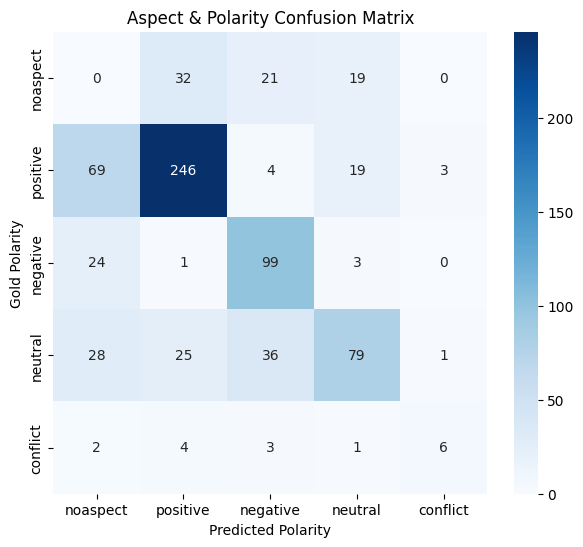

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel("Gold Polarity")
    plt.xlabel("Predicted Polarity")
    plt.title("Aspect & Polarity Confusion Matrix")
    plt.show()

cm = evaluate_confusion_matrix(dataset["test"], model, tokenizer)
plot_confusion_matrix(cm, labels)
